# Do some scatter plots on the editC (epsilon score) 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
from scipy import stats
from tqdm import tnrange, tqdm_notebook

### Prior to rebuttal, we were looking at all exons.

In [2]:
bulk_input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/window_outputs/'
sc_input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/window_outputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/window_outputs/'

bulk_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.txt' # for RBFOX2 and RPS2
# bulk_expr_key = 'results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
bulk_expr_key = 'results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'

In [3]:
def counts_to_rpkm(feature_counts_table):
    """
    takes featureCounts counts.txt and returns RPKM
    """
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

counts_table = pd.read_csv(bulk_expr_counts, sep='\t', index_col=0, skiprows=1)
counts_table = counts_table[['Chr','Start','End','Strand','Length', bulk_expr_key]]
counts_table.head()

,Chr,Start,End,Strand,Length,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,
ENSG00000223972.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,0
ENSG00000227232.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,97
ENSG00000243485.2,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,0
ENSG00000237613.2,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,0
ENSG00000268020.2,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,7


In [4]:
tpm = counts_to_tpm(counts_table)
tpm.sort_values(by=[bulk_expr_key], inplace=True, ascending=False)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [5]:
expressed_genes = tpm[tpm[bulk_expr_key] > 0].index
print(len(expressed_genes))

23754


### Use scored_edits.txt from 12_combine_scored_windows_from_11.ipynb

In [6]:
sc_editc = pd.read_csv(os.path.join(sc_input_dir, 'scored_edits.txt'), sep='\t', index_col=0)
sc_editc.head()

,APOBEC-STAMP_possorted_genome_bam_MD,APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv,APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv,For_Motif_ALL_edits_barcodes_0_1,For_Motif_Background_APO_plus_RBFOX2-TIA1_APO_edits_barcodes_4_5,HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-19_barcodes.tsv,HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-20_barcodes.tsv,HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-21_barcodes.tsv,HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-22_barcodes.tsv,HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-23_barcodes.tsv,...,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-6_barcodes_noCS.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes.tsv,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand10.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand100.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand200.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand300.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand50.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.rand500.txt,RBFOX2-TIA1-STAMP_round2E_read1_feature_FB_possorted_genome_bam_MD-7_barcodes_noCS.txt,RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,0.000388,0.000357,0.000357,0.003777,0.001257,0.000122,0.000141,0.000298,0.002041,0.000304,...,0.001011,0.009952,0.003135,0.007869,0.009621,0.008208,0.006650,0.009260,0.009313,0.007075
ENSG00000000419.8,0.000325,0.000285,0.000285,0.004342,0.001304,0.000000,0.000434,0.000378,0.002917,0.000388,...,0.002050,0.012227,0.006849,0.009983,0.011188,0.011204,0.027888,0.010568,0.011227,0.008207
ENSG00000000457.9,0.000153,0.001866,0.001866,0.000392,0.000139,0.000224,0.002794,0.000000,0.002055,0.000000,...,0.000303,0.001757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000310,0.000747
ENSG00000000460.12,0.000358,0.000320,0.000320,0.000631,0.000396,0.000250,0.000560,0.000436,0.000424,0.000452,...,0.001566,0.001064,0.000000,0.000000,0.000000,0.001690,0.000000,0.001213,0.000879,0.001749
ENSG00000000938.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
for c in sc_editc.columns:
    print(c)

APOBEC-STAMP_possorted_genome_bam_MD
APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv
APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv
For_Motif_ALL_edits_barcodes_0_1
For_Motif_Background_APO_plus_RBFOX2-TIA1_APO_edits_barcodes_4_5
HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-19_barcodes.tsv
HEK-NPC-APOBEC-STAMP_possorted_genome_bam_MD-20_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-21_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-22_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-23_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-24_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-25_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-26_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-30_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-31_barcodes.tsv
HEK-NPC-RBFOX2-STAMP_possorted_genome_bam_MD-32_barcodes.tsv
RBFOX2-TIA1-STAMP_possorted_genome_bam_MD-33_barcodes.tsv
RBFOX2-TIA1-STAMP_possorted_geno

In [8]:
bulk_editc = pd.read_csv(os.path.join(bulk_input_dir, 'scored_edits.txt'), sep='\t', index_col=0)
bulk_editc.head()

,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_merged_R1,APOBEC_only_50_merged_R1,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-1000_S21_L002_R1_001.21M,ApoControl-50_S14_L002_R1_001,...,TI_59_S16_L001_R1_001.10M,TI_5_S4_L001_R1_001,TI_7_S5_L001_R1_001,TI_8_S6_L001_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,0.000105,0.000708,0.000279,0.000000,0.000467,0.000329,0.000090,0.000859,0.001102,0.000465,...,0.002474,0.000105,0.000656,0.000239,0.000219,0.000272,0.002802,0.000692,0.000798,0.000392
ENSG00000000419.8,0.000000,0.000408,0.000000,0.000351,0.000840,0.000000,0.000203,0.000662,0.000638,0.000249,...,0.001650,0.000000,0.000577,0.000000,0.000000,0.000271,0.001170,0.002818,0.000543,0.000572
ENSG00000000457.9,0.000000,0.000000,0.000000,0.000313,0.000000,0.000000,0.000216,0.000000,0.000000,0.000000,...,0.000000,0.000324,0.000000,0.000138,0.000126,0.000000,0.000286,0.000747,0.000000,0.000728
ENSG00000000460.12,0.000000,0.000145,0.000000,0.000160,0.000165,0.000213,0.000234,0.000556,0.000541,0.000451,...,0.000440,0.000431,0.000468,0.000279,0.000269,0.000089,0.000861,0.000954,0.000371,0.000094
ENSG00000001036.9,0.000139,0.000547,0.000432,0.000185,0.000451,0.000493,0.000261,0.000743,0.000871,0.000207,...,0.001260,0.000100,0.000624,0.000346,0.000078,0.000279,0.000675,0.000405,0.000096,0.000000


In [9]:
counter = 0
for c in bulk_editc.columns:
    print(c)

ABCE1-0_S1_L001_R1_001
ABCE1-1000_S15_L002_R1_001
ABCE1-50_S8_L001_R1_001
APOBEC_only_0_merged_R1
APOBEC_only_1000_merged_R1
APOBEC_only_50_merged_R1
ApoControl-0_S7_L001_R1_001
ApoControl-1000_S21_L002_R1_001
ApoControl-1000_S21_L002_R1_001.21M
ApoControl-50_S14_L002_R1_001
Apobec-T_1_S28_L003_R1_001
Apobec-T_2_S29_L003_R1_001
Apobec_plusT_1_S30_L003_R1_001
Apobec_plusT_2_S31_L003_R1_001
ETF1-0_S2_L001_R1_001
ETF1-1000_S16_L002_R1_001
ETF1-50_S9_L001_R1_001
GSTP1-0_S3_L001_R1_001
GSTP1-1000_S17_L002_R1_001
GSTP1-50_S10_L001_R1_001
RBFOX2-0_S6_L001_R1_001
RBFOX2-1000_S20_L002_R1_001
RBFOX2-50_S13_L002_R1_001
RBFOX2-T_1_S32_L003_R1_001
RBFOX2-T_2_S33_L003_R1_001
RBFOX2_plusT_1_S34_L003_R1_001
RBFOX2_plusT_2_S35_L003_R1_001
RBFOX_0_48hr_merged_R1
RBFOX_0_72hr_merged_R1
RBFOX_1000_48hr_merged_R1
RBFOX_1000_72hr_merged_R1
RBFOX_50_48hr_merged_R1
RBFOX_50_72hr_merged_R1
RPS2-0_S4_L001_R1_001
RPS2-1000_S18_L002_R1_001
RPS2-1000_S18_L002_R1_001.21M
RPS2-50_S11_L001_R1_001
RPS2-T_1_S36_L003_R1

In [10]:
col1 = 'RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt'
col2 = 'RPS2-1000_S18_L002_R1_001'

In [11]:
merged = pd.merge(
    bulk_editc, 
    sc_editc, 
    how='outer', 
    left_index=True, 
    right_index=True
)
merged.fillna(0, inplace=True)
merged = merged[[col1, col2]]
# merged = merged[(merged[col1]>0) | (merged[col2]>0)]
print(merged.shape[0])
prefiltered = set(merged.index)
merged.head()

15386


,RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-1000_S18_L002_R1_001
Geneid,,
ENSG00000000003.10,0.007075,0.028695
ENSG00000000419.8,0.008207,0.016719
ENSG00000000457.9,0.000747,0.000785
ENSG00000000460.12,0.001749,0.008655
ENSG00000000938.8,0.000000,0.000000


In [12]:
merged_expressed_only = merged.loc[expressed_genes]

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [13]:
merged_expressed_only.fillna(0, inplace=True)
merged_expressed_only.shape[0]

23754

In [14]:
merged_expressed_only.corr()

,RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,RPS2-1000_S18_L002_R1_001
RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt,1.000000,0.677094
RPS2-1000_S18_L002_R1_001,0.677094,1.000000


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


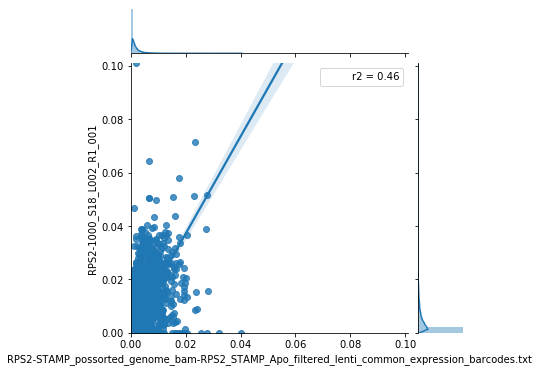

In [15]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

plot = sns.jointplot(
    x=col1, 
    y=col2, 
    data=merged_expressed_only, 
    kind="reg", 
    stat_func=r2,
    xlim=(0, merged.max().max()), 
    ylim=(0, merged.max().max())
)

plot.savefig(os.path.join(output_dir, '{}.{}.png'.format(col1, col2)))
plot.savefig(os.path.join(output_dir, '{}.{}.svg'.format(col1, col2)))